# Import Dependencies

In [2]:
import pandas as pd

# Read data file to dict of pandas dataframes

In [3]:
db_file = './data/question_database_schema.xlsx'
dict_of_dfs = pd.read_excel(db_file, sheet_name = None)

print(dict_of_dfs.keys())

dict_keys(['learning_objectives', 'course_objective_description', 'questions', 'answer_choices', 'exams', 'exams_learning_objectives', 'distractor_type', 'student_question_responses'])


In [4]:
print(dict_of_dfs['questions'])

    question_id learning_objective_id other_possible_choices certainty
0          1A01                    66                    NaN       NaN
1          1A02                    25                    NaN       NaN
2          1A03                     3                      4       NaN
3          1A04                     4                    NaN       NaN
4          1A05                     2                    NaN       NaN
..          ...                   ...                    ...       ...
204        4C22                    21                    NaN       NaN
205        4C23                    27                    NaN       NaN
206        4C24                    28                    NaN       NaN
207        4C25                    29                    NaN       NaN
208        4C26                    29                    NaN       NaN

[209 rows x 4 columns]


# Exam descriptions

### Number of exams: 4

- Exam 1: 
    - 2 forms (A, B)
    - 16 Questions
      - 2 with 5 options
      - 14 with 4 options
- Exam 2: 3 forms (A, B, C)
    - 16 Questions
      - 1 with 3 options
      - 15 with 4 options
- Exam 3: 3 forms (A, B, C)
    - 17 Questions
      - 17 with 4 options
- Exam 4: 3 forms (A, B, C)
    - 26 Questions
      - 25 with 4 options
      - 1 with 3 options (which form of the exam do you have?)


In [5]:
completed_answer_choices = dict_of_dfs['answer_choices']
student_responses        = dict_of_dfs['student_question_responses']
#convert option_id to number indexed at 1.
if 'A' in pd.unique(completed_answer_choices['option_id']):
    completed_answer_choices['option_id'] = completed_answer_choices['option_id'] = [ ord(letter) - 64 for letter in completed_answer_choices['option_id'] ]




student_responses = student_responses[student_responses['question_id'].isin(pd.unique(completed_answer_choices['question_id']))]

student_responses = student_responses[~student_responses["question_id"].isin(["4A01", "4B01", "4C01"])]
completed_answer_choices = completed_answer_choices[~completed_answer_choices["question_id"].isin(["4A01", "4B01", "4C01"])]

student_responses_with_details = pd.merge(
    left=student_responses, 
    right=completed_answer_choices,
    how='left',
    left_on=['question_id', 'selected_option'],
    right_on=['question_id', 'option_id'],
)

number_of_distractors_chosen = len(student_responses_with_details[student_responses_with_details['is_distractor'] > .5])
number_of_correct_answers_chosen = len(student_responses_with_details[student_responses_with_details['is_distractor'] < .5])
number_of_questions = len(student_responses_with_details)

print(f"Number of questions: {number_of_questions}.\nNumber of correct answers chosen: {number_of_correct_answers_chosen}.\nNumber of distractors chosen: {number_of_distractors_chosen}")

Number of questions: 16853.
Number of correct answers chosen: 12535.
Number of distractors chosen: 4247


In [6]:
number_of_solution_based_distractors = len(student_responses_with_details[student_responses_with_details['distractor_type'] == 2])

In [7]:
print(f"Number of distractors chosen: {number_of_distractors_chosen}. Number of solution-based distractors chosen: {number_of_solution_based_distractors}")

Number of distractors chosen: 4247. Number of solution-based distractors chosen: 1799


In [8]:
completed_answer_choices

,question_id,option_id,is_distractor,distractor_type,distractor_learning_objective_understanding,notes
0,1A01,1,1,2,66.0,Ignore middle term
1,1A01,2,1,2,66.0,Ignore middle term
2,1A01,3,1,5,66.0,7*8=56 vs 54
3,1A01,4,1,5,66.0,7*8=56 vs 54
4,1A01,5,0,0,66.0,Trinomial is prime
...,...,...,...,...,...,...
820,4C25,4,1,6,NaN,NaN
821,4C26,1,1,1,NaN,NaN
822,4C26,2,1,7,NaN,NaN
823,4C26,3,0,0,NaN,NaN


In [9]:
exam_question_distractor_count_frame = completed_answer_choices.groupby(by = 'distractor_type').count()["question_id"].reset_index().rename(columns = {"question_id": "count", "distractor_type": "distractor_id"})

exam_question_distractor_count_frame = pd.merge(
    left=exam_question_distractor_count_frame, 
    right=dict_of_dfs['distractor_type'],
    how='left',
    left_on=['distractor_id'],
    right_on=['distractor_id'],
)
exam_question_distractor_count_frame["percent"] = exam_question_distractor_count_frame["count"] / exam_question_distractor_count_frame["count"].sum() 

display(exam_question_distractor_count_frame)

,distractor_id,count,distractor_type,explanation,percent
0,0,206,solution,Solution based on expected student thinking fo...,0.249697
1,1,242,solution_based,Answer based on manipulating the solution that...,0.293333
2,2,211,question_learning_objective_understanding,Answer based on level of conception associated...,0.255758
3,3,1,other_learning_objective_understanding,Answer based on level of conception associated...,0.001212
4,4,3,representation,Answer based on a different representation tha...,0.003636
5,5,34,mechanics_based,Answer based on mechanical error with expected...,0.041212
6,6,40,unsure,It be like that sometimes,0.048485
7,7,85,distractor_based,Answer based on manipulating another option,0.103030
8,8,3,concept-based doppleganger,Answer based on conception but modified to loo...,0.003636


In [10]:
student_responses_distractor_selection_counts = student_responses_with_details.groupby(by = 'distractor_type').count()["question_id"].reset_index().rename(columns = {"question_id": "count", "distractor_type": "distractor_id"})
student_responses_distractor_selection_counts = pd.merge(
    left=student_responses_distractor_selection_counts, 
    right=dict_of_dfs['distractor_type'],
    how='left',
    left_on=['distractor_id'],
    right_on=['distractor_id'],
)
student_responses_distractor_selection_counts["percent"] = student_responses_distractor_selection_counts["count"] / student_responses_distractor_selection_counts["count"].sum() 
display(student_responses_distractor_selection_counts)

,distractor_id,count,distractor_type,explanation,percent
0,0.0,12535,solution,Solution based on expected student thinking fo...,0.746931
1,1.0,1613,solution_based,Answer based on manipulating the solution that...,0.096115
2,2.0,1799,question_learning_objective_understanding,Answer based on level of conception associated...,0.107198
3,3.0,9,other_learning_objective_understanding,Answer based on level of conception associated...,0.000536
4,4.0,32,representation,Answer based on a different representation tha...,0.001907
5,5.0,264,mechanics_based,Answer based on mechanical error with expected...,0.015731
6,6.0,207,unsure,It be like that sometimes,0.012335
7,7.0,305,distractor_based,Answer based on manipulating another option,0.018174
8,8.0,18,concept-based doppleganger,Answer based on conception but modified to loo...,0.001073


# Effective Distractor Analysis

In [11]:
distractor_selection_counts = student_responses_with_details.groupby(by = ['question_id', 'selected_option']).count()
distractor_selection_counts = distractor_selection_counts.rename(columns = {"student_id": "count"})["count"].to_frame().reset_index()
distractor_selection_counts = pd.merge(
    left=completed_answer_choices[["question_id", "option_id", "is_distractor"]],
    right = distractor_selection_counts,
    how='left',
    left_on=['question_id', 'option_id'],
    right_on=['question_id', 'selected_option'],
)
distractor_selection_counts = distractor_selection_counts.drop(columns = ["selected_option"])
distractor_selection_counts = distractor_selection_counts.fillna(0)
distractor_selection_counts["percent"] = distractor_selection_counts["count"] 
distractor_selection_counts["exam_id"] = distractor_selection_counts["question_id"].str[:2]
question_id_columns = pd.unique(distractor_selection_counts["question_id"].values)

for question_id in question_id_columns:
    question_selection_frame = distractor_selection_counts[distractor_selection_counts["question_id"].isin([question_id])]
    question_selection_frame.loc[:, "percent"] = question_selection_frame["count"]/question_selection_frame["count"].sum()
    distractor_selection_counts[distractor_selection_counts["question_id"].isin([question_id])] = question_selection_frame


## Percentage of Distractors Chosen by Form

In [12]:
exam_ids = pd.unique(distractor_selection_counts["exam_id"].values)
distractors_chosen_list = []
for exam_id in exam_ids:
    exam_distractors_chosen_dict = dict()
    exam_distractors_chosen_dict["exam_id"] = exam_id
    exam_selection_frame = distractor_selection_counts[distractor_selection_counts["exam_id"].isin([exam_id])]
    exam_selection_frame = exam_selection_frame[exam_selection_frame["is_distractor"] == 1]
    exam_distractors_chosen_dict["never_chosen"] = len(exam_selection_frame[exam_selection_frame["percent"] == 0])
    exam_distractors_chosen_dict["rarely_chosen"] = len(exam_selection_frame[(exam_selection_frame["percent"] > 0) & (exam_selection_frame["percent"] <= 0.05)])
    exam_distractors_chosen_dict["sometimes_chosen"] = len(exam_selection_frame[exam_selection_frame["percent"] > 0.05])
    exam_distractors_chosen_dict["total_distractors"] = len(exam_selection_frame)
    distractors_chosen_list.append(exam_distractors_chosen_dict)
exam_distractors_chosen_frame = pd.DataFrame(distractors_chosen_list)
exam_distractors_chosen_frame["never_chosen_percent"] = exam_distractors_chosen_frame["never_chosen"] / exam_distractors_chosen_frame["total_distractors"]
exam_distractors_chosen_frame["rarely_chosen_percent"] = exam_distractors_chosen_frame["rarely_chosen"] / exam_distractors_chosen_frame["total_distractors"]
exam_distractors_chosen_frame["sometimes_chosen_percent"] = exam_distractors_chosen_frame["sometimes_chosen"] / exam_distractors_chosen_frame["total_distractors"]

print(exam_distractors_chosen_frame)

exam_distractors_chosen_frame["exam_form_id"] = exam_distractors_chosen_frame["exam_id"]
exam_distractors_chosen_frame["form"] = exam_distractors_chosen_frame["exam_id"].str[1]
exam_distractors_chosen_frame["exam_id"] = exam_distractors_chosen_frame["exam_id"].str[0]


   exam_id  never_chosen  rarely_chosen  sometimes_chosen  total_distractors  \
0       1A             1             18                31                 50   
1       1B             4             18                28                 50   
2       2A             3             18                26                 47   
3       2B             3             17                27                 47   
4       2C             0             18                29                 47   
5       3A             7             20                24                 51   
6       3B             4             27                20                 51   
7       3C            11             21                19                 51   
8       4A             7             25                43                 75   
9       4B            13             22                40                 75   
10      4C            17             30                28                 75   

    never_chosen_percent  rarely_chosen

## Number of effective distractors per question per form

In [13]:
def create_effective_distractor_counts_list():
    return [0, 0, 0, 0, 0]

distractor_selection_counts["is_effective"] = distractor_selection_counts["percent"] > 0.05

effective_distractor_count_dict = dict()

for question_id in question_id_columns:
    question_selection_frame = distractor_selection_counts[distractor_selection_counts["question_id"].isin([question_id])]
    question_selection_frame = question_selection_frame[question_selection_frame["is_distractor"] == 1]
    exam_id = question_selection_frame["exam_id"].values[0]
    number_of_effective_distractors = question_selection_frame["is_effective"].sum()
    if exam_id not in effective_distractor_count_dict.keys():
        effective_distractor_count_dict[exam_id] = create_effective_distractor_counts_list()
    effective_distractor_count_dict[exam_id][number_of_effective_distractors] += 1

for key in effective_distractor_count_dict.keys():
    list_sum = sum(effective_distractor_count_dict[key])
    for i in range(len(effective_distractor_count_dict[key])):
        effective_distractor_count_dict[key][i] = effective_distractor_count_dict[key][i] / list_sum
    print(key, effective_distractor_count_dict[key])

1A [0.125, 0.1875, 0.3125, 0.375, 0.0]
1B [0.125, 0.1875, 0.5, 0.1875, 0.0]
2A [0.0625, 0.375, 0.4375, 0.125, 0.0]
2B [0.1875, 0.125, 0.5, 0.1875, 0.0]
2C [0.125, 0.25, 0.3125, 0.3125, 0.0]
3A [0.29411764705882354, 0.23529411764705882, 0.23529411764705882, 0.23529411764705882, 0.0]
3B [0.29411764705882354, 0.4117647058823529, 0.11764705882352941, 0.17647058823529413, 0.0]
3C [0.4117647058823529, 0.23529411764705882, 0.17647058823529413, 0.17647058823529413, 0.0]
4A [0.12, 0.32, 0.28, 0.28, 0.0]
4B [0.2, 0.24, 0.32, 0.24, 0.0]
4C [0.32, 0.32, 0.28, 0.08, 0.0]


# Item Difficulty

In [14]:
item_difficulty_frame = distractor_selection_counts[distractor_selection_counts["is_distractor"] == 0]

item_difficulty_frame = item_difficulty_frame[["question_id", "exam_id", "count", "percent"]]
item_difficulty_frame = item_difficulty_frame.rename(columns = {"percent": "item_difficulty"})

item_difficulty_frame[item_difficulty_frame["exam_id"].isin(["4A"])]

,question_id,exam_id,count,item_difficulty
527,4A02,4A,50.0,0.657895
532,4A03,4A,32.0,0.432432
535,4A04,4A,50.0,0.657895
537,4A05,4A,74.0,0.973684
543,4A06,4A,74.0,0.973684
547,4A07,4A,65.0,0.855263
552,4A08,4A,69.0,0.907895
556,4A09,4A,69.0,0.907895
560,4A10,4A,16.0,0.213333
563,4A11,4A,63.0,0.840000


## Distributions

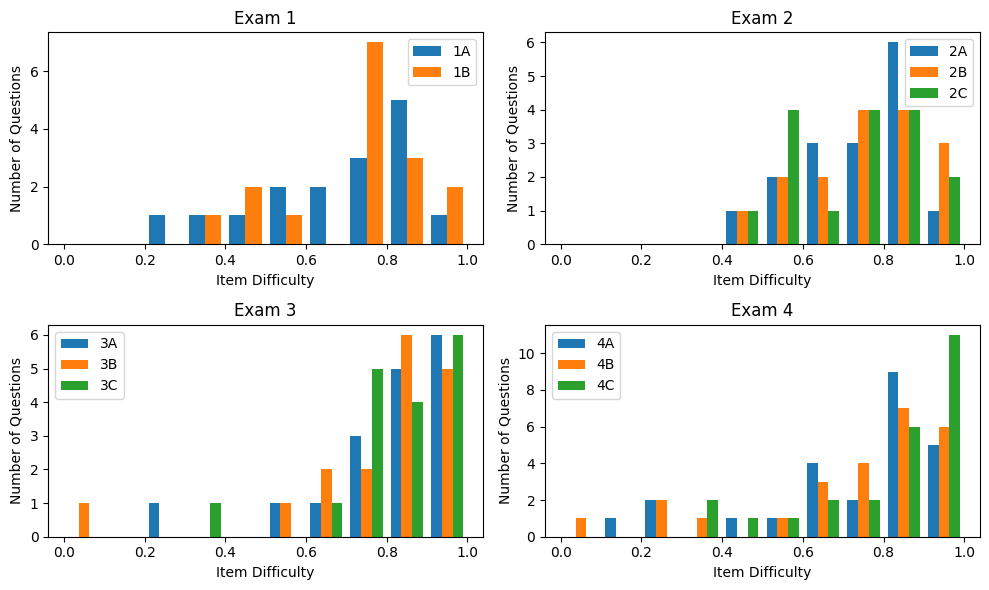

In [32]:
def add_subplot(axis, bins, exam_keys, title):
    data_list = []
    for key in exam_keys:
        data_list.append(item_difficulty_frame[item_difficulty_frame["exam_id"].isin([key])]["item_difficulty"].values)
    axis.hist(data_list, bins, histtype='bar', label=exam_keys)
    axis.legend(prop={'size': 10})
    axis.set_xlabel("Item Difficulty")
    axis.set_ylabel("Number of Questions")
    axis.set_title(title)


import matplotlib.pyplot as plt
import numpy as np

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]


fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

add_subplot(ax0, bins, ["1A", "1B"], "Exam 1")
add_subplot(ax1, bins, ["2A", "2B", "2C"], "Exam 2")
add_subplot(ax2, bins, ["3A", "3B", "3C"], "Exam 3")
add_subplot(ax3, bins, ["4A", "4B", "4C"], "Exam 4")

fig.tight_layout()
plt.show()

In [16]:
mean_series = item_difficulty_frame.groupby(by = ["exam_id"])["item_difficulty"].mean()
summary_frame = mean_series.to_frame()
summary_frame = summary_frame.rename(columns={"item_difficulty": "mean"})
summary_frame["median"] = item_difficulty_frame.groupby(by = ["exam_id"])["item_difficulty"].median()
summary_frame["std"] = item_difficulty_frame.groupby(by = ["exam_id"])["item_difficulty"].std()
summary_frame["skewness"] = item_difficulty_frame.groupby(by = ["exam_id"])["item_difficulty"].skew()
summary_frame["kurtosis"] = item_difficulty_frame.groupby(by = ["exam_id"])["item_difficulty"].apply(pd.Series.kurtosis)
print(summary_frame)

             mean    median       std  skewness  kurtosis
exam_id                                                  
1A       0.677037  0.700855  0.204214 -0.697836 -0.446712
1B       0.715651  0.775556  0.179328 -1.026785  0.130079
2A       0.750931  0.783784  0.136385 -0.688406 -0.617707
2B       0.751537  0.780228  0.150050 -0.712022 -0.292234
2C       0.724304  0.751709  0.146787 -0.306430 -1.307208
3A       0.786539  0.826667  0.185049 -1.847236  3.946419
3B       0.777191  0.875000  0.223945 -2.453745  7.198709
3C       0.817889  0.863014  0.171764 -1.824701  4.326618
4A       0.716848  0.815789  0.241965 -1.429591  1.245015
4B       0.736173  0.800000  0.247963 -1.375489  1.048038
4C       0.804458  0.891892  0.181516 -1.282937  0.784075


# Point-Biserial Correlation

In [17]:
student_score_frame = student_responses_with_details[["question_id", "student_id", "is_distractor"]].copy()
student_score_frame["exam_id"] = student_score_frame["question_id"].str[:2]
student_score_frame.loc[:, "question_score"] = (student_score_frame.loc[:, "is_distractor"] == 0).astype(int)

student_score_frame = student_score_frame.drop(columns=["is_distractor"])

student_score_frame["exam_score"] = student_score_frame.loc[:, "question_score"]

student_id_list = np.unique(student_score_frame["student_id"].values)

for student_id in student_id_list:
    student_exam_frame = student_score_frame[student_score_frame["student_id"].isin([student_id])]
    exam_id_list = np.unique(student_exam_frame["exam_id"].values) 
    for exam_id in exam_id_list:
        student_score_frame_for_one_exam =  student_exam_frame[student_exam_frame["exam_id"].isin([exam_id])]
        student_score_frame.loc[student_score_frame_for_one_exam.index.values, "exam_score"] = student_score_frame_for_one_exam["question_score"].sum() - student_score_frame_for_one_exam["question_score"]


In [22]:
point_biserial_correlation_frame = student_score_frame.groupby(by = ["question_id"])[["question_score", "exam_score"]].corr()

point_biserial_correlation_frame = point_biserial_correlation_frame["question_score"].reset_index()
point_biserial_correlation_frame = point_biserial_correlation_frame[point_biserial_correlation_frame["level_1"] == "exam_score"].drop(columns="level_1")
point_biserial_correlation_frame = point_biserial_correlation_frame.rename(columns={"question_score": "pbc"})
point_biserial_correlation_frame["p_value"] = point_biserial_correlation_frame["pbc"]

for index, row in point_biserial_correlation_frame.iterrows():
    question_id = row["question_id"]
    student_question_response_frame = student_score_frame[student_score_frame["question_id"].isin([question_id])]
    p_value = student_question_response_frame["question_score"].sum()/len(student_question_response_frame)
    point_biserial_correlation_frame.loc[index, "p_value"] = p_value

point_biserial_correlation_frame["exam_id"] = point_biserial_correlation_frame["question_id"].str[0:2]

print(point_biserial_correlation_frame)

    question_id       pbc   p_value exam_id
1          1A01  0.262974  0.700855      1A
3          1A02  0.423430  0.564103      1A
5          1A03  0.282799  0.846154      1A
7          1A04  0.241062  0.700855      1A
9          1A05  0.102329  0.418803      1A
..          ...       ...       ...     ...
403        4C22  0.376259  0.391892      4C
405        4C23  0.304223  0.891892      4C
407        4C24  0.559897  0.729730      4C
409        4C25  0.198047  0.810811      4C
411        4C26  0.323034  0.932432      4C

[206 rows x 4 columns]


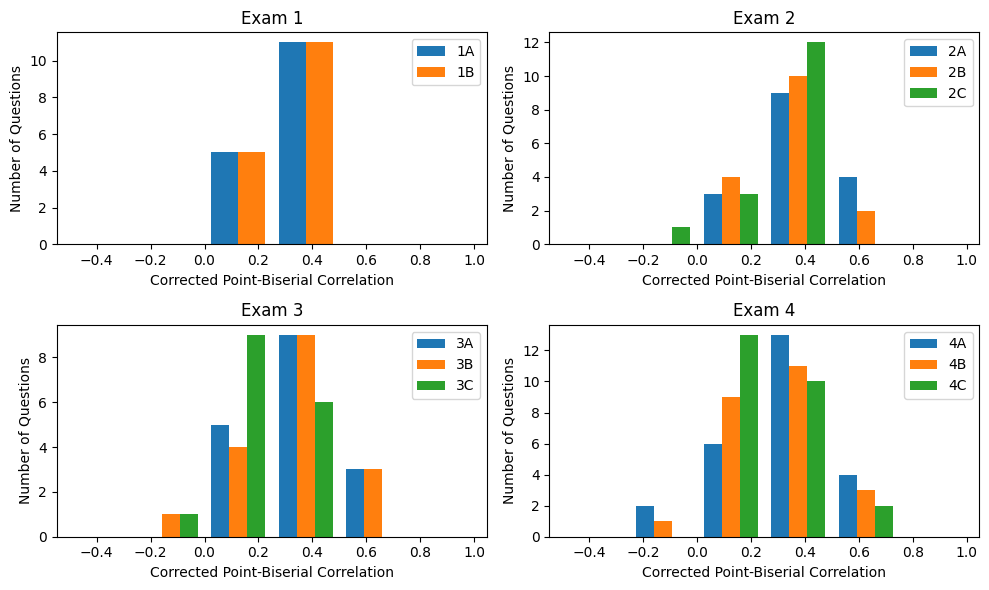

In [30]:
def add_subplot(axis, bins, exam_keys, title):
    data_list = []
    for key in exam_keys:
        data_list.append(point_biserial_correlation_frame[point_biserial_correlation_frame["exam_id"].isin([key])]["pbc"].values)
    axis.hist(data_list, bins, histtype='bar', label=exam_keys)
    axis.legend(prop={'size': 10})
    axis.set_xlabel("Corrected Point-Biserial Correlation")
    axis.set_ylabel("Number of Questions")
    axis.set_title(title)


import matplotlib.pyplot as plt
import numpy as np

bins = [-.5, -.25, 0, 0.25, 0.5, 0.75, 1]


fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

add_subplot(ax0, bins, ["1A", "1B"], "Exam 1")
add_subplot(ax1, bins, ["2A", "2B", "2C"], "Exam 2")
add_subplot(ax2, bins, ["3A", "3B", "3C"], "Exam 3")
add_subplot(ax3, bins, ["4A", "4B", "4C"], "Exam 4")

fig.tight_layout()
plt.show()

In [40]:
bins = [-.5, 0, 0.15, 0.25, 1]
point_biserial_correlation_frame_binned = point_biserial_correlation_frame.groupby(['exam_id', pd.cut(point_biserial_correlation_frame["pbc"], bins)]).size().unstack()

point_biserial_correlation_frame_binned = 100 * point_biserial_correlation_frame_binned/point_biserial_correlation_frame_binned.sum(axis=0, numeric_only=True)
point_biserial_correlation_frame_binned

/tmp/ipykernel_314628/4105398406.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  point_biserial_correlation_frame_binned = point_biserial_correlation_frame.groupby(['exam_id', pd.cut(point_biserial_correlation_frame["pbc"], bins)]).size().unstack()


pbc,"(-0.5, 0.0]","(0.0, 0.15]","(0.15, 0.25]","(0.25, 1.0]"
exam_id,,,,
1A,0.000000,8.695652,6.976744,8.333333
1B,0.000000,4.347826,9.302326,8.333333
2A,0.000000,4.347826,4.651163,9.848485
2B,0.000000,4.347826,6.976744,9.090909
2C,16.666667,4.347826,4.651163,9.090909
3A,0.000000,4.347826,9.302326,9.090909
3B,16.666667,0.000000,9.302326,9.090909
3C,16.666667,17.391304,11.627907,4.545455
4A,33.333333,13.043478,6.976744,12.878788


## KR-20 Computation

In [43]:
student_score_frame = student_responses_with_details[["question_id", "student_id", "is_distractor"]].copy()
student_score_frame["exam_id"] = student_score_frame["question_id"].str[:2]
student_score_frame.loc[:, "question_score"] = (student_score_frame.loc[:, "is_distractor"] == 0).astype(int)

student_score_frame = student_score_frame.drop(columns=["is_distractor"])

student_score_frame["exam_score"] = student_score_frame.loc[:, "question_score"]

student_id_list = np.unique(student_score_frame["student_id"].values)

for student_id in student_id_list:
    student_exam_frame = student_score_frame[student_score_frame["student_id"].isin([student_id])]
    exam_id_list = np.unique(student_exam_frame["exam_id"].values) 
    for exam_id in exam_id_list:
        student_score_frame_for_one_exam =  student_exam_frame[student_exam_frame["exam_id"].isin([exam_id])]
        student_score_frame.loc[student_score_frame_for_one_exam.index.values, "exam_score"] = student_score_frame_for_one_exam["question_score"].sum() - student_score_frame_for_one_exam["question_score"]


In [44]:
print(student_score_frame)

      question_id  student_id exam_id  question_score  exam_score
0            1B01       40926      1B               1          14
1            1B02       40926      1B               1          14
2            1B03       40926      1B               1          14
3            1B04       40926      1B               1          14
4            1B05       40926      1B               0          15
...           ...         ...     ...             ...         ...
16848        4A22    99687243      4A               1          22
16849        4A23    99687243      4A               1          22
16850        4A24    99687243      4A               1          22
16851        4A25    99687243      4A               1          22
16852        4A26    99687243      4A               0          23

[16853 rows x 5 columns]
